<a href="https://colab.research.google.com/github/PragyaKumari2203/Image-Captioning-Model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-requisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/Image-Captioning-Model

/content/drive/MyDrive/Image-Captioning-Model


In [ ]:
# Install dependencies
!pip install -r requirements.txt

# **Data Preparation**




In [1]:
import os
import torch
from torch import nn
from transformers import AutoTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import numpy as np
import random

In [3]:
PATH_TO_CAPTIONS = "/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt"
PATH_TO_IMAGES = "/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset"
PATH_TO_TRAINING_DATA = "/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt"
PATH_TO_VALIDATION_DATA = "/content/drive/MyDrive/Flickr8k_text/Flickr_8k.devImages.txt"
PATH_TO_TEST_DATA = "/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt"

## Loading image-caption pairs

In [4]:
def load_captions(filename):
  captions = {}
  with open(filename, 'r', encoding='utf-8') as f:
    for line in f:
      parts = line.strip().split('\t')
      if len(parts) < 2:
        continue
      jpg_filename, caption = parts[0] .split('#')[0], parts[1]
      if jpg_filename not in captions:
        captions[jpg_filename] = []
      captions[jpg_filename].append(caption)
  return captions

## Image and text preprocessing

In [6]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(caption,max_length = 30):
  tokens = tokenizer(
      caption,
      max_length = max_length,
      padding = "max_length",
      truncation = True,
      return_tensors = "pt"
  )
  return tokens.input_ids.squeeze(0), tokens.attention_mask.squeeze(0)

def image_transforms():
    return transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

## Writing Custom Dataset

In [7]:
class Flickr8kDataset(Dataset):
  def __init__(self,image_dir,captions_dict,image_filenames,tokenizer=None,transform=None,max_length=30):
    """
        Args:
            image_dir (str): Path to the directory containing images.
            captions_dict (dict): Dictionary mapping image filenames to a list of captions.
            image_filenames (list): List of image filenames for this dataset split (train/val/test).
            tokenizer: Hugging Face tokenizer for captions.
            transform: Image transformations.
            max_length (int): Maximum token length for captions, default = 30.
    """
    self.image_dir = image_dir
    self.captions_dict = captions_dict
    self.image_filenames = image_filenames
    self.tokenizer = tokenizer
    self.transform = transform
    self.max_length = max_length

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self,idx):
    image_filename = self.image_filenames[idx]
    image_path = os.path.join(self.image_dir,image_filename)
    image = Image.open(image_path).convert("RGB")

    if self.transform:
      image = self.transform(image)

    captions = self.captions_dict[image_filename]
    caption_sel = captions[torch.randint(0,len(captions),(1,)).item()]
    input_ids, attention_mask = self.tokenizer(caption_sel, self.max_length)

    return image, input_ids, attention_mask

In [8]:
def image_list(filepath):
  with open(filepath,'r') as f:
    return [line.strip() for line in f.readlines()]

training_data = image_list(PATH_TO_TRAINING_DATA)
validation_data = image_list(PATH_TO_VALIDATION_DATA)
test_data = image_list(PATH_TO_TEST_DATA)

print(f"Number of training images: {len(training_data)}")
print(f"Number of validation images: {len(validation_data)}")
print(f"Number of test images: {len(test_data)}")

Number of training images: 6000
Number of validation images: 1000
Number of test images: 1000


In [9]:
captions = load_captions(PATH_TO_CAPTIONS)

example_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

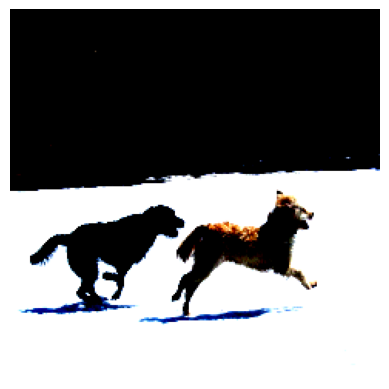

Tokenized IDs: tensor([  101,  2304,  3899, 11777,  2829,  3899,  2083,  4586,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Input IDs to text: [CLS] black dog chasing brown dog through snow [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Input IDs to tokens: ['[CLS]', 'black', 'dog', 'chasing', 'brown', 'dog', 'through', 'snow', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [10]:
fig = plt.figure()
image, input_ids, attention_mask = example_dataset[0]
plt.imshow(image.permute(1,2,0))
plt.axis('off')
plt.show()

print(f"Tokenized IDs: {input_ids}")
print(f"Input IDs to text: {tokenizer.decode(input_ids)}")
print(f"Input IDs to tokens: {tokenizer.convert_ids_to_tokens(input_ids)}")

## Creating dataloaders

In [11]:
training_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = training_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

valid_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = validation_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

test_dataset = Flickr8kDataset(
    image_dir = PATH_TO_IMAGES,
    captions_dict = captions,
    image_filenames = test_data,
    tokenizer = tokenize,
    transform = image_transforms(),
    max_length = 30
)

In [14]:
train_dataloader = DataLoader(training_dataset,batch_size = 32,shuffle = True, num_workers = 2)
valid_dataloader = DataLoader(valid_dataset,batch_size = 32,shuffle = False,num_workers = 2)
test_dataloader = DataLoader(test_dataset,batch_size = 32,shuffle = False,num_workers = 2)

In [15]:
for batch in train_dataloader:
    images, input_ids, attn_masks = batch
    print(f"Batch Image Shape: {images.shape}")
    print(f"Batch Token Shape: {input_ids.shape}")
    print(f"Batch Attention Mask Shape: {attn_masks.shape}")
    break

Batch Image Shape: torch.Size([32, 3, 240, 240])
Batch Token Shape: torch.Size([32, 30])
Batch Attention Mask Shape: torch.Size([32, 30])


# Model Architecture

## Model definition

In [16]:
class Encoder(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # Use EfficientNet-B0 for better size matching
        self.cnn = models.efficientnet_b0(weights='DEFAULT')
        # Remove the final classification layer
        self.cnn.classifier = nn.Identity()
        # Project to BERT's embedding space
        self.projection = nn.Linear(1280, embed_dim)

    def forward(self, images):
        features = self.cnn(images)  # [batch_size, 1280]
        return self.projection(features)  # [batch_size, embed_dim]

class Decoder(nn.Module):
    def __init__(self, embed_dim, vocab_size):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        # Freeze BERT parameters (recommended for initial training)
        for param in self.bert.parameters():
            param.requires_grad = False
        self.token_embeddings = self.bert.embeddings.word_embeddings
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, input_ids, attention_mask, image_embeds):
        # image_embeds: [batch_size, embed_dim]
        # input_ids: [batch_size, seq_len]

        # Create extended attention mask
        batch_size = input_ids.size(0)
        seq_length = input_ids.size(1)

        # [CLS] token acts as image prefix
        extended_attention_mask = torch.cat([
            torch.ones(batch_size, 1, device=input_ids.device),  # for image
            attention_mask
        ], dim=1)

        # Combine image and text embeddings
        text_embeds = self.token_embeddings(input_ids)  # [batch_size, seq_len, embed_dim]
        inputs_embeds = torch.cat([
            image_embeds.unsqueeze(1),  # [batch_size, 1, embed_dim]
            text_embeds
        ], dim=1)

        outputs = self.bert(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            return_dict=True
        )

        # Only predict for text positions (not image position)
        text_output = outputs.last_hidden_state[:, 1:, :]
        return self.output_layer(text_output)

In [17]:
class ImageCaptioningModel(nn.Module):
  def __init__(self,embed_dim,vocab_size):
    super(ImageCaptioningModel,self).__init__()
    self.encoder = Encoder(embed_dim)
    self.decoder = Decoder(embed_dim,vocab_size)

  def forward(self,images,input_ids,attention_mask):
    # images = [batch,3,240,240]
    # input_ids = [batch,max_length]
    # attention_mask = [batch,max_length]

    # image_features = [batch_size,embed_dim]
    image_features = self.encoder(images)
    # output = [batch_size,max_length,vocab_size]
    outputs = self.decoder(input_ids, attention_mask, image_features)
    return outputs

# Training the model

## Model initialization

In [18]:
# embed_dim = 768  #BERT's embedding dimension
# vocab_size = tokenizer.vocab_size   #BERT's vocab size
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ImageCaptioningModel(embed_dim,vocab_size).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

# Recommended hyperparameters
config = {
    'batch_size': 32,
    'embed_dim': 768,  # Must match BERT's hidden size
    'learning_rate': 3e-5,
    'epochs': 10,
    'max_length': 30,
    'temperature': 0.7,
    'top_k': 50,
    'weight_decay': 0.01
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model with these settings
model = ImageCaptioningModel(embed_dim=config['embed_dim'],
                           vocab_size=tokenizer.vocab_size).to(device)

# Use AdamW optimizer (better for transformers)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# Use label smoothing for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


# embed_dim = 768  #BERT's embedding dimension
# vocab_size = tokenizer.vocab_size   #BERT's vocab size
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = ImageCaptioningModel(embed_dim,vocab_size).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 28,462,774 trainable parameters


## Training and evaluation loops

In [22]:
def train_fn(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for images, captions, attention_masks in dataloader:
        images = images.to(device)
        captions = captions.to(device)
        attention_masks = attention_masks.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, captions[:, :-1], attention_masks[:, :-1])

        # Calculate loss (ignore padding tokens)
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            captions[:, 1:].reshape(-1))

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluation_fn(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, captions, attention_masks in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            attention_masks = attention_masks.to(device)

            outputs = model(images, captions[:, :-1], attention_masks[:, :-1])

            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                captions[:, 1:].reshape(-1))

            total_loss += loss.item()

    return total_loss / len(dataloader)

## Finetuning

In [23]:
print(f"Training on: {device}")

Training on: cuda


In [24]:
def generate_caption(model, image_path, tokenizer, device, max_length=30, temperature=1.0, top_k=50):
    model.eval()

    # Load and process image
    image = Image.open(image_path).convert("RGB")
    transform = image_transforms()
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Get image embedding
    with torch.no_grad():
        image_embed = model.encoder(image_tensor)  # [1, embed_dim]

    # Initialize with [CLS] token
    input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
    generated_ids = []

    for _ in range(max_length):
        # Create attention mask
        attention_mask = torch.ones_like(input_ids)

        with torch.no_grad():
            outputs = model.decoder(input_ids, attention_mask, image_embed)
            next_token_logits = outputs[:, -1, :] / temperature

            # Apply top-k filtering
            if top_k > 0:
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                next_token_logits[indices_to_remove] = -float('Inf')

            # Sample from the distribution
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)

        # Break if [SEP] token is generated
        if next_token_id.item() == tokenizer.sep_token_id:
            break

        generated_ids.append(next_token_id.item())
        input_ids = torch.cat([input_ids, next_token_id], dim=1)

    caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    return caption

In [25]:
# n_epochs = 5
# best_eval_loss = float('inf')

# for epoch in range(n_epochs):
#   train_loss = train_fn(model,train_dataloader,optimizer,criterion,device)
#   eval_loss = evaluation_fn(model,valid_dataloader,criterion,device)

#   if eval_loss < best_eval_loss:
#     best_eval_loss = eval_loss
#     torch.save(model.state_dict(), "best_model.pth")

#   print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_loss:.4f}")
#   print(f"Validation Loss: {eval_loss / len(valid_dataloader):.4f}")
#   print("-"*50)


best_val_loss = float('inf')
for epoch in range(config['epochs']):
    train_loss = train_fn(model, train_dataloader, optimizer, criterion, device)
    val_loss = evaluation_fn(model, valid_dataloader, criterion, device)

    print(f"Epoch {epoch+1}/{config['epochs']}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Saved new best model")

    # Test generation
    test_image = random.choice(test_data)
    test_path = os.path.join(PATH_TO_IMAGES, test_image)
    caption = generate_caption(model, test_path, tokenizer, device)
    print(f"Sample Generation: {caption}\n")

Epoch 1/10
Train Loss: 8.3328 | Val Loss: 5.7623
Saved new best model
Sample Generation: of pac body furry of sheep at ledge slideer rock woman of look head stands blue white its set flying fluffy loads phrase look oliver look look running body

Epoch 2/10
Train Loss: 5.1539 | Val Loss: 3.9163
Saved new best model
Sample Generation: with men ball ball snow at at with on girls walking at as building and swimming lawn ball people as with people is ball jumping over woman man his large

Epoch 3/10
Train Loss: 3.9640 | Val Loss: 3.6449
Saved new best model
Sample Generation: and is running of brown through at a in playing holding three numbers its the the grass person,. of children shirt on woman

Epoch 4/10
Train Loss: 3.6603 | Val Loss: 3.5572
Saved new best model
Sample Generation: ball over dog the a blue and with

Epoch 5/10
Train Loss: 3.5232 | Val Loss: 3.5095
Saved new best model
Sample Generation: .,

Epoch 6/10
Train Loss: 3.4311 | Val Loss: 3.4174
Saved new best model
Sample Gen

## Model evaluation

In [26]:
model.load_state_dict(torch.load("best_model.pth"))
test_loss = evaluation_fn(model, test_dataloader, criterion, device)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.139 | Test PPL:  23.088 |


# Caption generation

In [ ]:
def generate_caption(model, image_path, tokenizer, device, max_length=30):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = image_transforms()
    # image_tensor = [3,240,240] => [1,3,240,240]
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        #image_features = [1,embed_dim]
        image_features = model.encoder(image_tensor)

    #input_ids = [1,1]
    input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
    #attention_mask = [1,1]
    attention_mask = torch.ones_like(input_ids, device=device)

    for _ in range(max_length):
        #outputs = [1,max_length,vocab_size]
        outputs = model.decoder(input_ids, attention_mask,image_features)
        #next_token_logits = [1,vocab_size]
        next_token_logits = outputs[:, -1, :]
        #next_token_id = [1] => [1,1]
        next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
        #input_ids = [1,t] => [1,t+1], t = length of input_ids
        input_ids = torch.cat([input_ids, next_token_id], dim=1)
        #attention_mask = same as input_ids
        attention_mask = torch.ones_like(input_ids)
        if next_token_id.item() in [tokenizer.sep_token_id, tokenizer.pad_token_id]:
            break

    caption = tokenizer.decode(input_ids[0][1:], skip_special_tokens=True)
    return caption

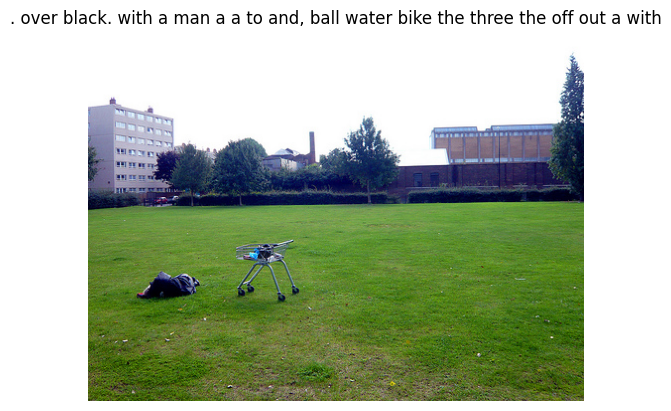

Caption: . over black. with a man a a to and, ball water bike the three the off out a with


In [31]:
test_image = random.choice(test_data)
test_image_path = os.path.join(PATH_TO_IMAGES,test_image)
caption = generate_caption(model,test_image_path,tokenizer,device)

image = Image.open(test_image_path)
plt.imshow(image)
plt.title(caption)
plt.axis('off')
plt.show()
print("Caption:", caption)